In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import json
import deepinv as dinv
from skimage.transform import iradon
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from itertools import repeat
import odl
from odl.phantom import ellipsoid_phantom
from odl import uniform_discr
from Model_arch import UNet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/home/ktaghavi/miniconda3/envs/msc_dip_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_psnr(original, denoised):
    """
    Compute PSNR between two NumPy arrays in [0,1], same shape.
    """
    eps = 1e-10
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = np.max(original)
    return 10 * np.log10(((max_pixel**2) + eps) / mse)

def nabla(x):
        r"""
        Applies the finite differences operator associated with tensors of the same shape as x.
        """
        b, c, h, w = x.shape
        u = torch.zeros((b, c, h, w, 2), device=x.device).type(x.dtype)
        u[:, :, :-1, :, 0] = u[:, :, :-1, :, 0] - x[:, :, :-1]
        u[:, :, :-1, :, 0] = u[:, :, :-1, :, 0] + x[:, :, 1:]
        u[:, :, :, :-1, 1] = u[:, :, :, :-1, 1] - x[..., :-1]
        u[:, :, :, :-1, 1] = u[:, :, :, :-1, 1] + x[..., 1:]
        return u

In [3]:
class OperatorFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, operator, x):
        # ctx.operator saved for backward
        ctx.operator = operator
        # call the DeepInv forward operator A
        with torch.no_grad():
            out = operator.A(x)
        # no need to save x unless A is nonlinear
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # in the backward pass, apply the adjoint A_adjoint
        operator = ctx.operator
        grad_input = operator.A_adjoint(grad_output)
        # first returned None says “no gradient for operator”
        return None, grad_input

class OperatorModule(torch.nn.Module):
    def __init__(self, operator):
        super().__init__()
        self.operator = operator

    def forward(self, x):
        # call our custom Function
        return OperatorFunction.apply(self.operator, x)

    def A_dagger(self, y):
        # if you ever want to call the adjoint directly
        return self.operator.A_dagger(y)

In [4]:
angles_torch = torch.linspace(0,180,60,device=device)
physics_raw = dinv.physics.Tomography(
    img_width=256, angles=angles_torch, device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.05)
)

physics = OperatorModule(physics_raw)

Data shape: torch.Size([1, 1, 256, 256])


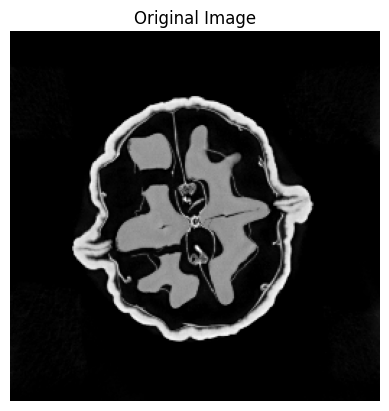

Data shape after unsqueeze: torch.Size([1, 1, 256, 256])


In [5]:
walnut_data = torch.load("walnut.pt", map_location=device)
walnut_data = walnut_data.to(device)

print("Data shape:", walnut_data.shape)

img_walnut = walnut_data.squeeze().cpu().numpy()
plt.imshow(img_walnut, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()
plt.close()

if walnut_data.ndim == 3:
    walnut_data = walnut_data.unsqueeze(0)
elif walnut_data.ndim == 2:
    walnut_data = walnut_data.unsqueeze(0).unsqueeze(0)
print("Data shape after unsqueeze:", walnut_data.shape)


### classical TV‐minimization in ODL

Iteration 4679, current converge crit. = 1.00E-05, objective = 1.00E-05 
FBP    PSNR: -65.02 dB
TV-PGD PSNR: 25.73 dB


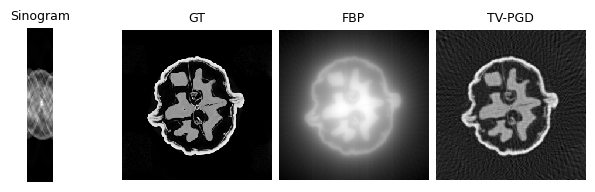

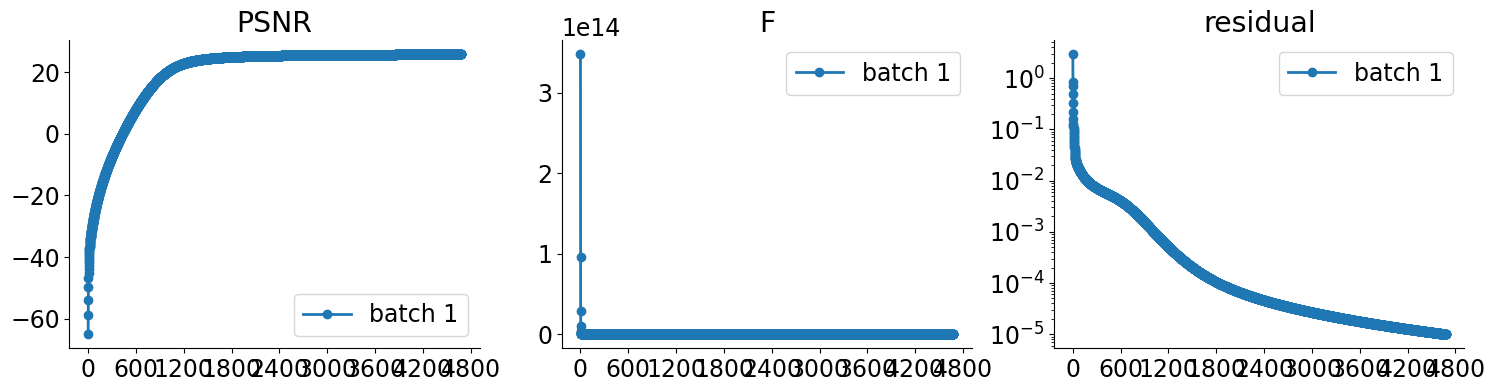

In [25]:
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior        import TVPrior
from deepinv.optim.optimizers   import optim_builder


if isinstance(walnut_data, dict):
    walnut = walnut_data["walnut"]
else:
    walnut = walnut_data
walnut = walnut.to(device)

# 3) Simulate data
y = physics_raw.A(walnut)    # forward project → [1,1,det,ang]

# 4) Set up TV–PGD solver
data_fidelity = L2()
prior = TVPrior(n_it_max=20)


# Algorithm parameters
verbose = True
stepsize = 1e-4 # stepsize for PGD
lamb = 1e-2  # TV regularisation parameter
params_algo = {"stepsize": stepsize, "lambda": lamb}
max_iter = 10000
early_stop = True

# Instantiate the algorithm class to solve the problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

# 5) Run FBP and TV–PGD
x_lin = physics_raw.A_adjoint(y)       # pure back‐projection
x_model, metrics = model(
    y,
    physics=physics_raw,
    x_gt=walnut,
    compute_metrics=True,
)

# 6) Compute PSNR
psnr_fbp = dinv.metric.PSNR()(walnut, x_lin).item()
psnr_tv  = dinv.metric.PSNR()(walnut, x_model).item()

print(f"FBP    PSNR: {psnr_fbp:.2f} dB")
print(f"TV-PGD PSNR: {psnr_tv:.2f} dB")

# 7) Plot results
imgs   = [y, walnut, x_lin, x_model]
titles = ["Sinogram", "GT", "FBP", "TV-PGD"]
dinv.utils.plot(imgs, titles=titles)

# 8) Plot convergence curves if available
if metrics:
    dinv.utils.plot_curves(metrics)
psnr_classic = metrics["psnr"][-1]

### DIP with Ellipses Pre Trained Weight

In [7]:
from Model_arch import UNet

angles_torch = torch.linspace(0, 180, 60, dtype = torch.float32, device=device) 
Height, Width = walnut_data.shape[-2], walnut_data.shape[-1]
physics_raw = dinv.physics.Tomography(
    img_width = Width, 
    angles=angles_torch, 
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.8)
)
physics_new = OperatorModule(physics_raw)

ellipse_model = UNet(1,1)
ellipse_pretrained_weight= torch.load("checkpoints/pre_model.pth", map_location=device)
ellipse_model.load_state_dict(ellipse_pretrained_weight)
ellipse_model.to(device)

UNet(
  (encoder1): Encoder(
    (conv1): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (downsample): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (encoder2): Encoder(
    (conv1): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (downsample): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

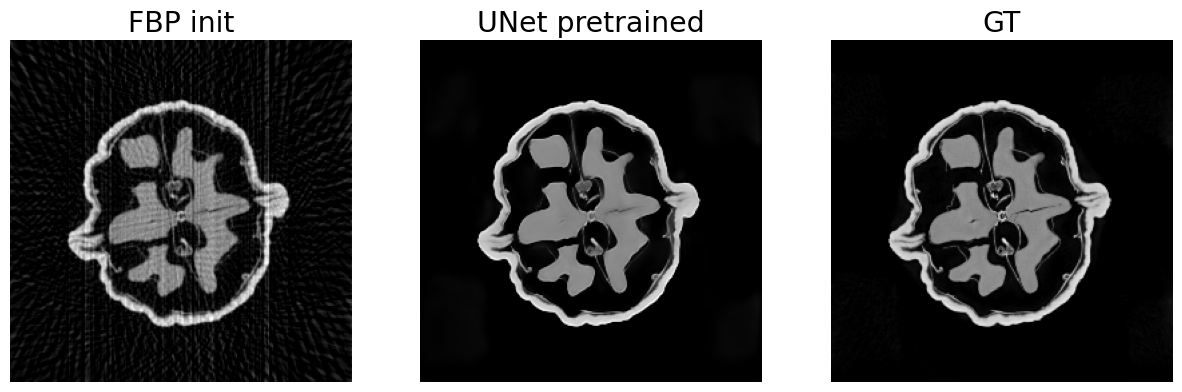

FBP PSNR: 22.78 dB
UNet PSNR: 31.48 dB


In [8]:
with torch.no_grad():
    y = physics(walnut_data)
    x0 = physics.A_dagger(y)

ellipse_model.eval()

with torch.no_grad():
    x_pre = ellipse_model(walnut_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip((ax1, ax2, ax3),
                          (x0, x_pre, walnut),
                          ("FBP init", "UNet pretrained", "GT")):
    ax.imshow(img.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(title); ax.axis("off")
plt.show()
psnr_fbp = dinv.metric.PSNR()(walnut_data, x0).item()
psnr_unet = dinv.metric.PSNR()(walnut_data, x_pre).item()
print(f"FBP PSNR: {psnr_fbp:.2f} dB")
print(f"UNet PSNR: {psnr_unet:.2f} dB")

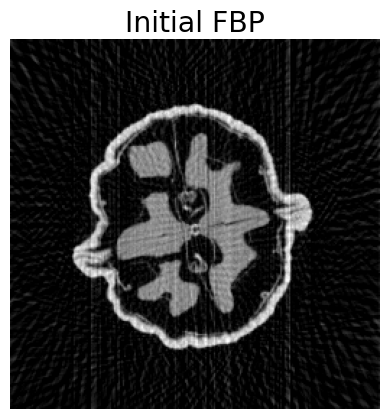

Initial PSNR: 22.78 dB
Epoch 0, Loss: 0.0011
PSNR: 31.25 dB


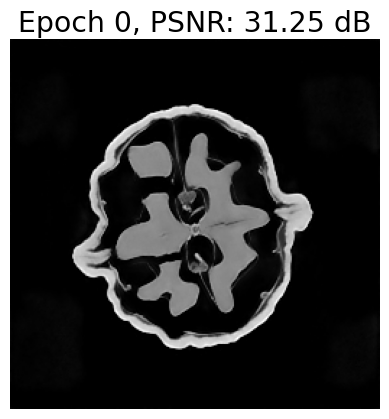

Epoch 100, Loss: 0.0005
PSNR: 38.58 dB


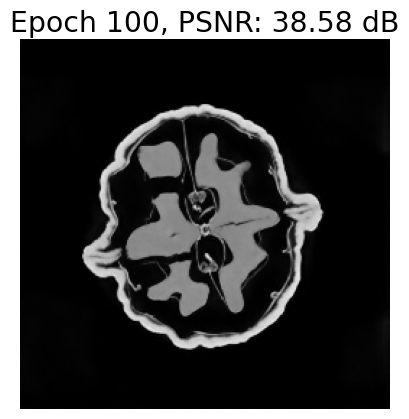

Epoch 200, Loss: 0.0004
PSNR: 40.35 dB


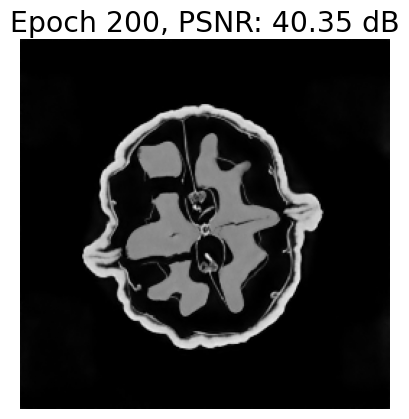

Epoch 300, Loss: 0.0004
PSNR: 41.63 dB


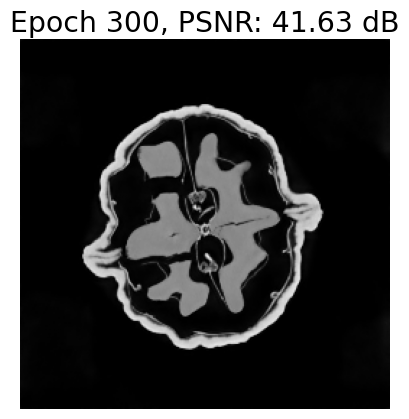

Epoch 400, Loss: 0.0004
PSNR: 42.72 dB


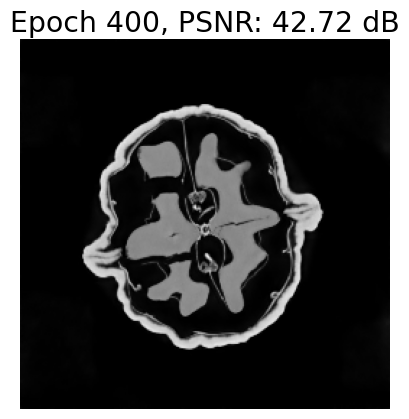

Epoch 500, Loss: 0.0004
PSNR: 43.58 dB


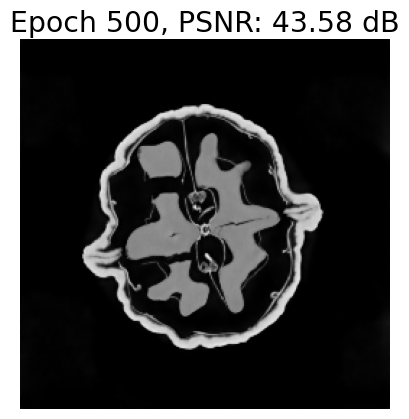

Epoch 600, Loss: 0.0003
PSNR: 44.35 dB


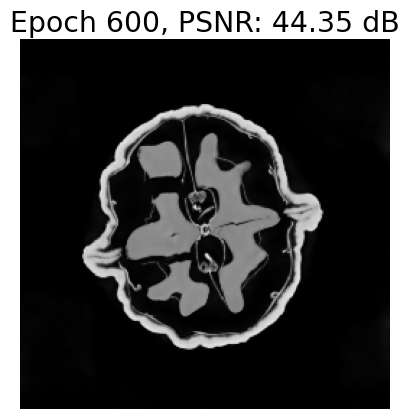

Epoch 700, Loss: 0.0003
PSNR: 44.92 dB


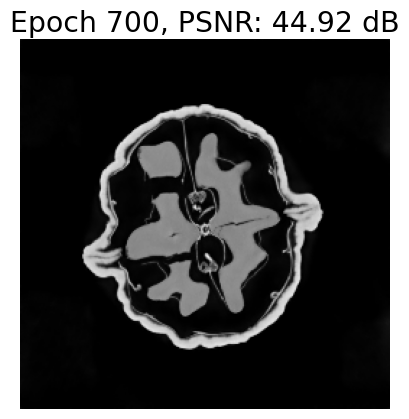

Epoch 800, Loss: 0.0003
PSNR: 45.37 dB


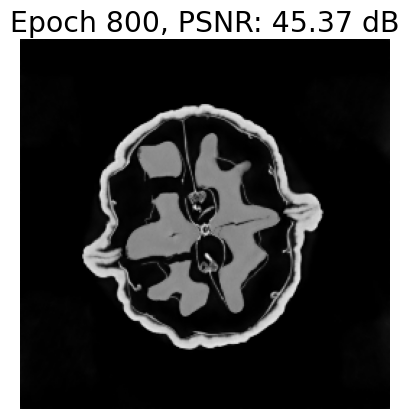

Epoch 900, Loss: 0.0003
PSNR: 45.76 dB


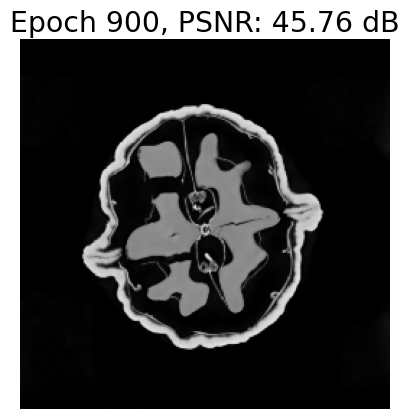

Epoch 1000, Loss: 0.0003
PSNR: 46.06 dB


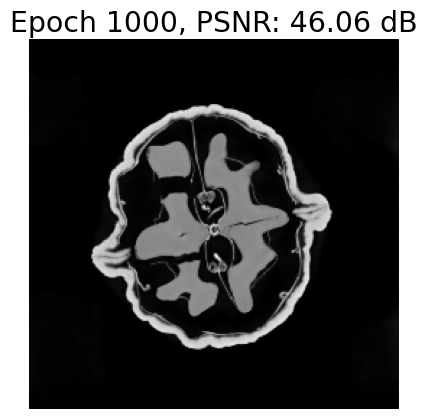

Epoch 1100, Loss: 0.0003
PSNR: 46.24 dB


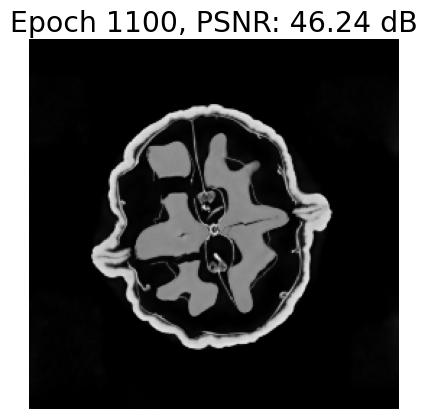

Epoch 1200, Loss: 0.0003
PSNR: 46.41 dB


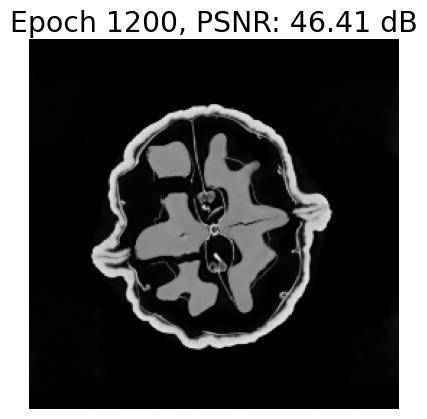

Epoch 1300, Loss: 0.0003
PSNR: 46.58 dB


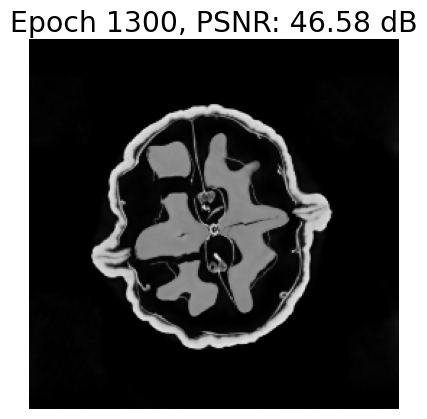

Epoch 1400, Loss: 0.0003
PSNR: 46.67 dB


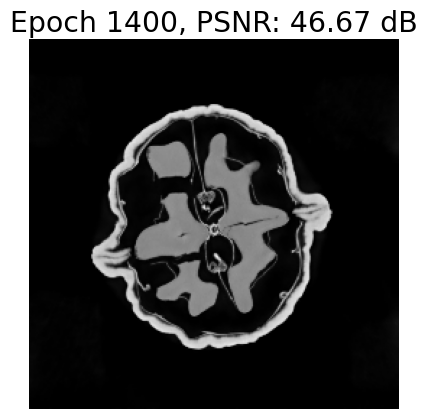

Epoch 1500, Loss: 0.0003
PSNR: 46.81 dB


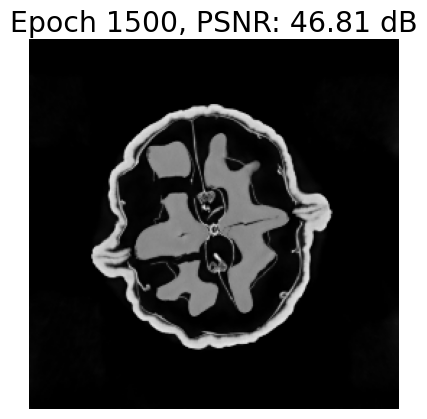

Epoch 1600, Loss: 0.0003
PSNR: 47.03 dB


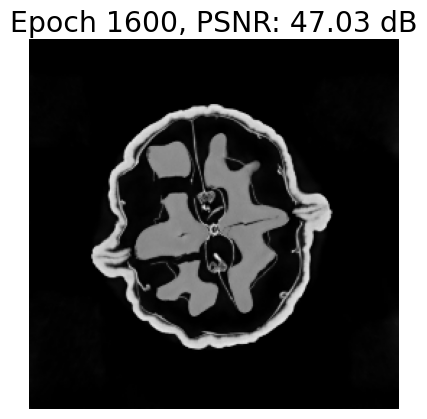

Epoch 1700, Loss: 0.0003
PSNR: 46.98 dB


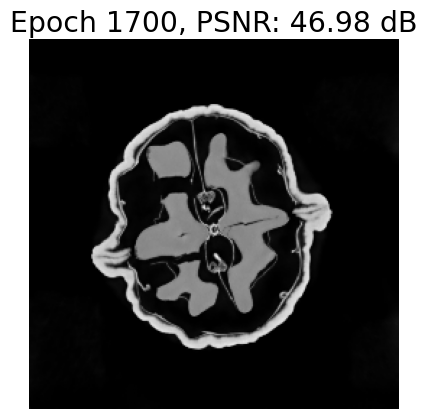

Epoch 1800, Loss: 0.0003
PSNR: 47.26 dB


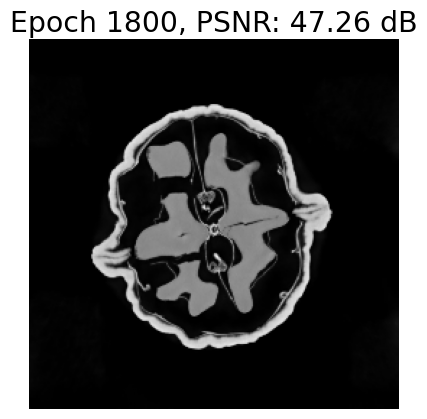

Epoch 1900, Loss: 0.0003
PSNR: 47.34 dB


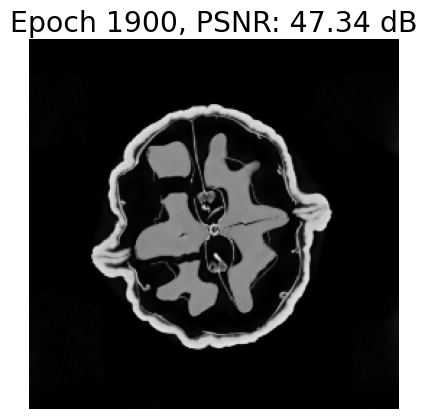

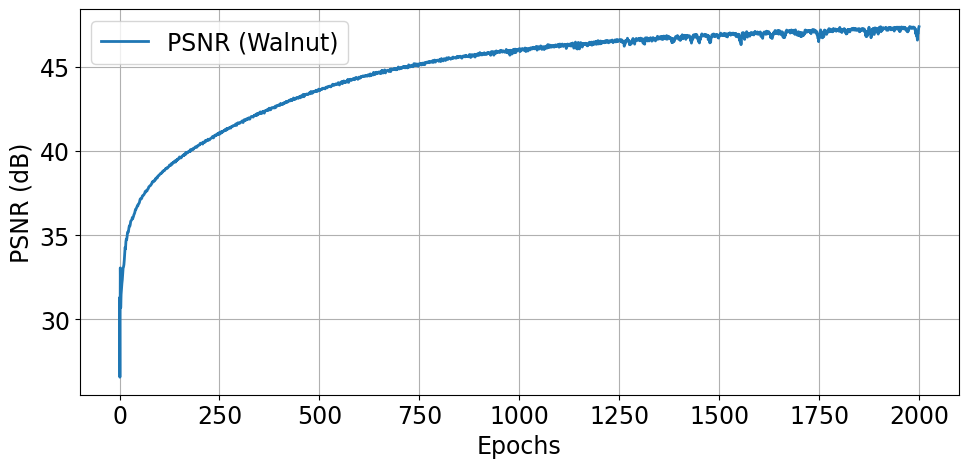

In [9]:
ellipse_model.train()
opt = torch.optim.Adam(ellipse_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
epochs = 2000
lambda_tv = 1e-3

# Initialize lists to store PSNR values
psnr_ellipses = []
for epoch in range(epochs):
    opt.zero_grad()

    with torch.no_grad():
        y = physics(walnut_data)
        x0 = physics.A_dagger(y)
        if epoch == 0:
            plt.imshow(x0.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title("Initial FBP")
            plt.axis('off')
            plt.show()
            plt.close()
            print(f"Initial PSNR: {dinv.metric.PSNR()(walnut_data, x0).item():.2f} dB")
    x_pre = ellipse_model(walnut_data)

    grad_u = nabla(x_pre)
    Dx = grad_u[..., 0]
    Dy = grad_u[..., 1]
    mag = torch.sqrt((Dx**2 + Dy**2).sum(dim=1) + 1e-10) # avoid division by zero
    TV_val = mag.mean()
    lambda_tv = 0.01 # TV regularization weight
    loss = loss_fn(x_pre, walnut_data) + lambda_tv * TV_val

    loss.backward()
    opt.step()
    psnr_value = dinv.metric.PSNR()(walnut_data, x_pre).item()
    psnr_ellipses.append(psnr_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        psnr = dinv.metric.PSNR()(walnut_data, x_pre).item()
        print(f"PSNR: {psnr:.2f} dB")
        plt.imshow(x_pre.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Epoch {epoch}, PSNR: {psnr:.2f} dB")
        plt.axis('off')
        plt.show()
        plt.close()
        
epochs_idx = list(range(len(psnr_ellipses)))
plt.figure(figsize=(10, 5))
plt.plot(epochs_idx, psnr_ellipses, label='PSNR (Walnut)')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### DIP with Disk Ellipses Pre Trained Weights

In [10]:
from Model_arch import UNet

angles_torch = torch.linspace(0, 180, 60, dtype = torch.float32, device=device) 
Height, Width = walnut_data.shape[-2], walnut_data.shape[-1]
physics_raw = dinv.physics.Tomography(
    img_width = Width, 
    angles=angles_torch, 
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.8)
)
physics_new = OperatorModule(physics_raw)

disk_model = UNet(1,1)
disk_pretrained_weight= torch.load("checkpoints/pre_disk_model.pth", map_location=device)
disk_model.load_state_dict(ellipse_pretrained_weight)
disk_model.to(device)

UNet(
  (encoder1): Encoder(
    (conv1): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (downsample): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (encoder2): Encoder(
    (conv1): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (downsample): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

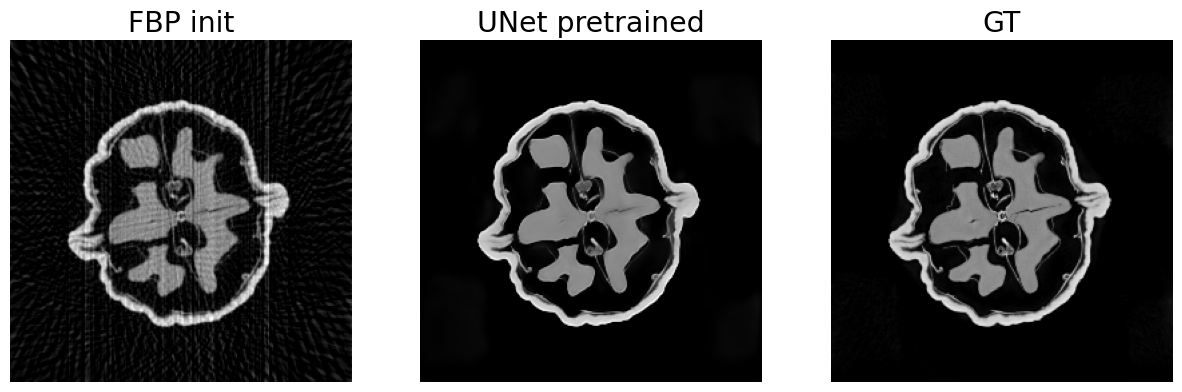

FBP PSNR: 22.78 dB
UNet PSNR: 31.48 dB


In [11]:
with torch.no_grad():
    y = physics(walnut_data)
    x0 = physics.A_dagger(y)

disk_model.eval()

with torch.no_grad():
    x_pre = disk_model(walnut_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip((ax1, ax2, ax3),
                          (x0, x_pre, walnut),
                          ("FBP init", "UNet pretrained", "GT")):
    ax.imshow(img.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(title); ax.axis("off")
plt.show()
psnr_fbp = dinv.metric.PSNR()(walnut_data, x0).item()
psnr_unet = dinv.metric.PSNR()(walnut_data, x_pre).item()
print(f"FBP PSNR: {psnr_fbp:.2f} dB")
print(f"UNet PSNR: {psnr_unet:.2f} dB")

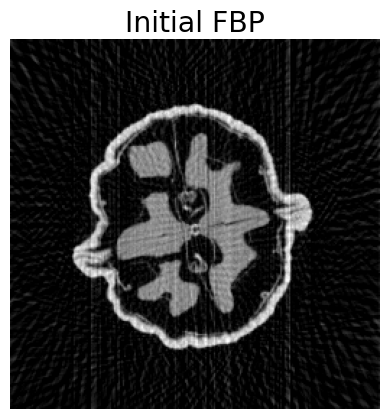

Initial PSNR: 22.78 dB
Epoch 0, Loss: 0.0011
PSNR: 31.30 dB


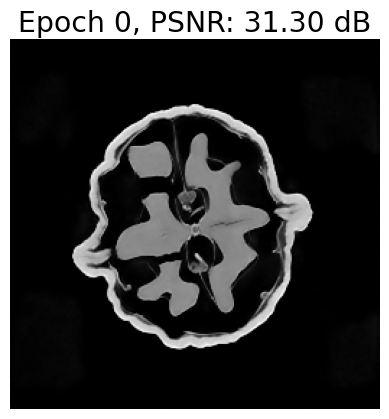

Epoch 100, Loss: 0.0004
PSNR: 38.65 dB


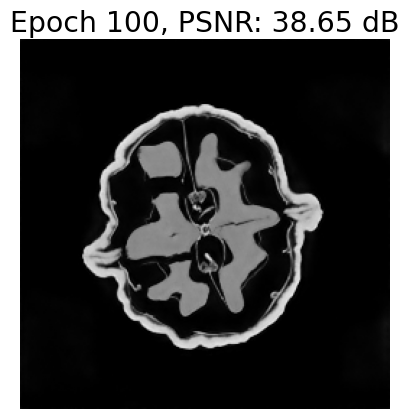

Epoch 200, Loss: 0.0004
PSNR: 40.45 dB


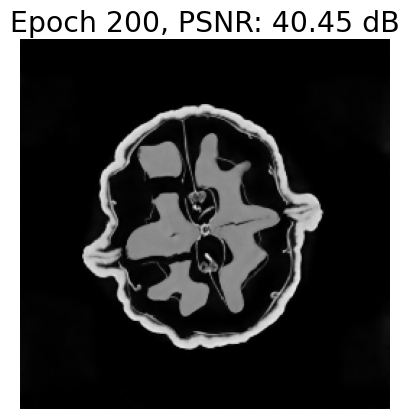

Epoch 300, Loss: 0.0004
PSNR: 41.74 dB


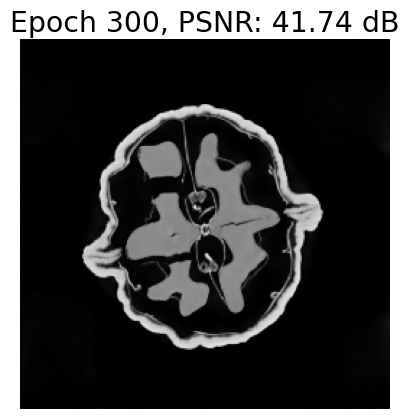

Epoch 400, Loss: 0.0004
PSNR: 42.83 dB


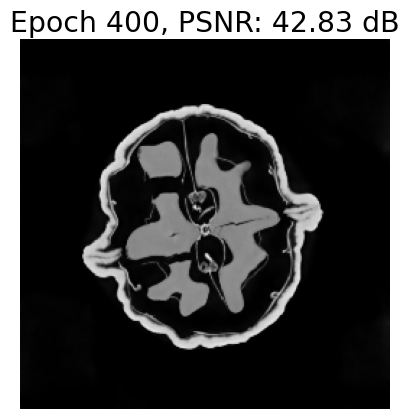

Epoch 500, Loss: 0.0004
PSNR: 43.64 dB


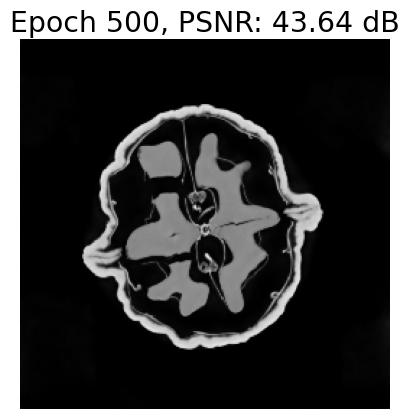

Epoch 600, Loss: 0.0003
PSNR: 44.52 dB


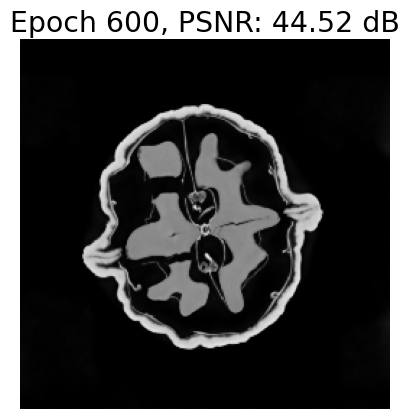

Epoch 700, Loss: 0.0003
PSNR: 45.03 dB


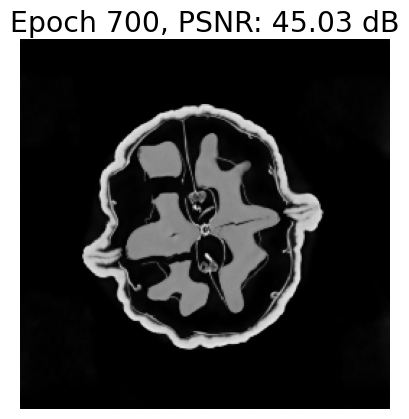

Epoch 800, Loss: 0.0003
PSNR: 45.48 dB


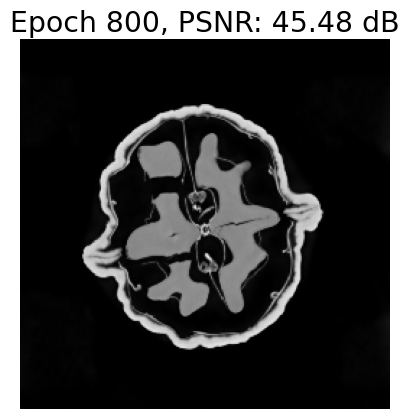

Epoch 900, Loss: 0.0003
PSNR: 45.76 dB


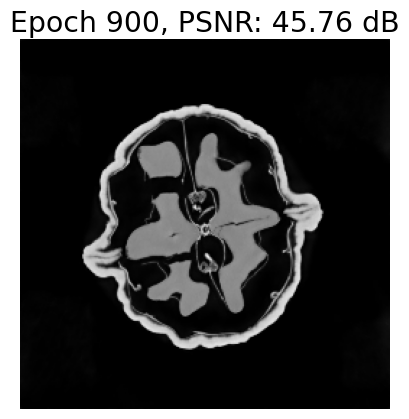

Epoch 1000, Loss: 0.0003
PSNR: 46.11 dB


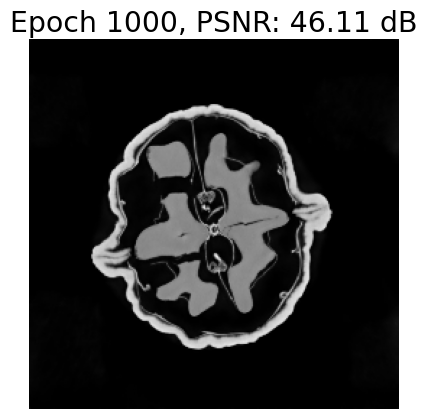

Epoch 1100, Loss: 0.0003
PSNR: 46.16 dB


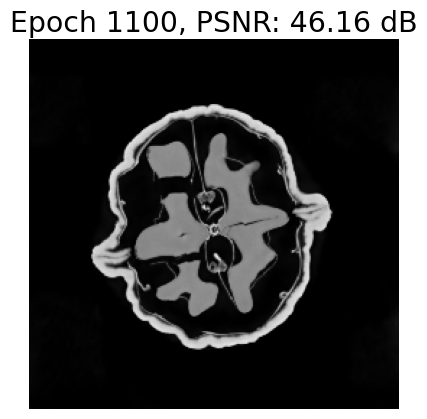

Epoch 1200, Loss: 0.0003
PSNR: 46.50 dB


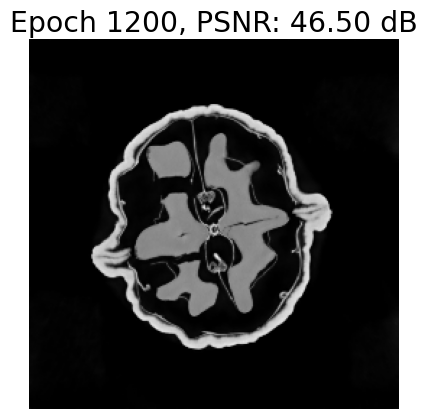

Epoch 1300, Loss: 0.0003
PSNR: 46.67 dB


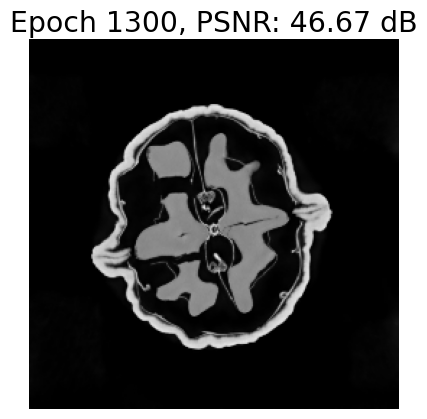

Epoch 1400, Loss: 0.0003
PSNR: 46.51 dB


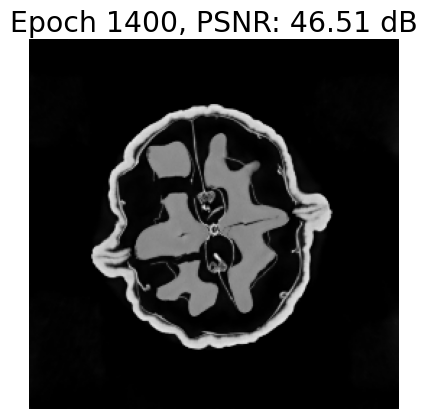

Epoch 1500, Loss: 0.0003
PSNR: 46.74 dB


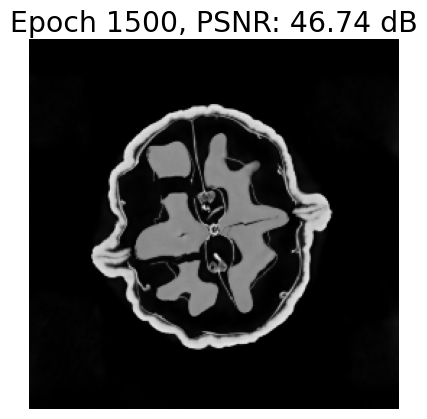

Epoch 1600, Loss: 0.0003
PSNR: 47.11 dB


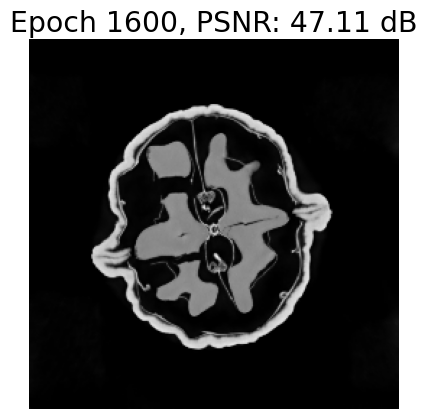

Epoch 1700, Loss: 0.0003
PSNR: 47.11 dB


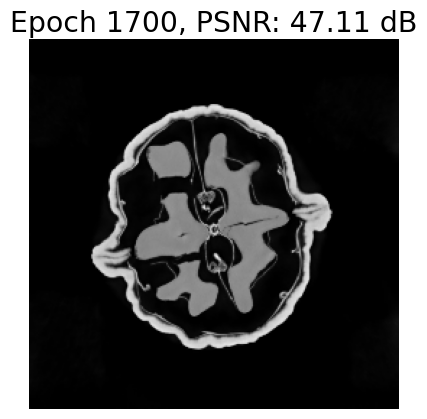

Epoch 1800, Loss: 0.0003
PSNR: 47.26 dB


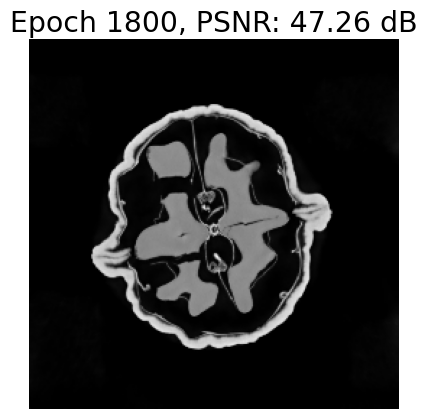

Epoch 1900, Loss: 0.0003
PSNR: 47.36 dB


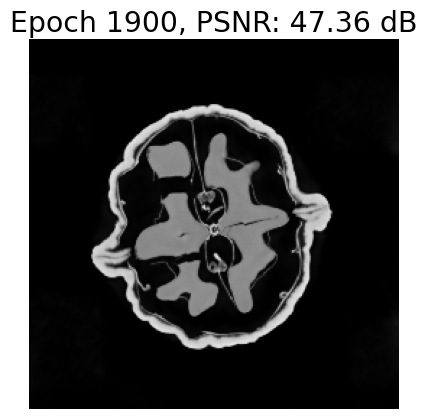

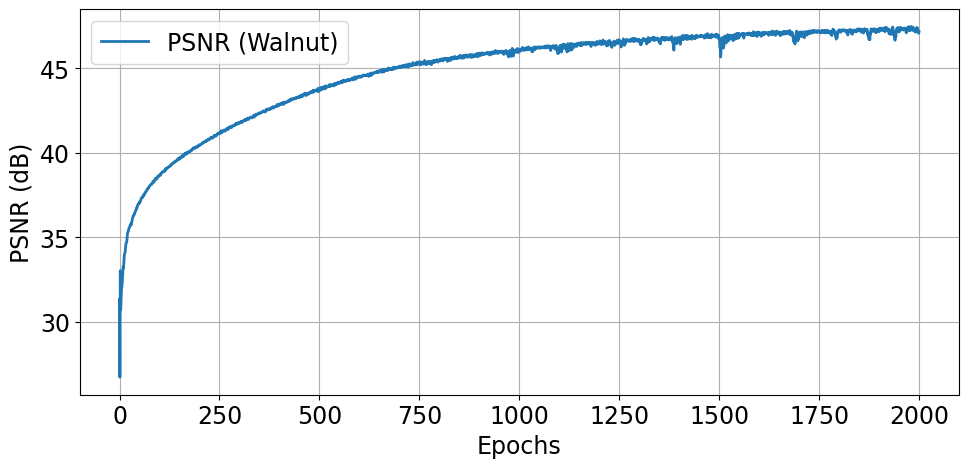

In [12]:
disk_model.train()
opt = torch.optim.Adam(disk_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
epochs = 2000
lambda_tv = 1e-3

# Initialize lists to store PSNR values
psnr_disk = []
for epoch in range(epochs):
    opt.zero_grad()

    with torch.no_grad():
        y = physics(walnut_data)
        x0 = physics.A_dagger(y)
        if epoch == 0:
            plt.imshow(x0.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title("Initial FBP")
            plt.axis('off')
            plt.show()
            plt.close()
            print(f"Initial PSNR: {dinv.metric.PSNR()(walnut_data, x0).item():.2f} dB")
    x_pre = disk_model(walnut_data)

    grad_u = nabla(x_pre)
    Dx = grad_u[..., 0]
    Dy = grad_u[..., 1]
    mag = torch.sqrt((Dx**2 + Dy**2).sum(dim=1) + 1e-10) # avoid division by zero
    TV_val = mag.mean()
    lambda_tv = 0.01 # TV regularization weight
    loss = loss_fn(x_pre, walnut_data) + lambda_tv * TV_val

    loss.backward()
    opt.step()
    psnr_value = dinv.metric.PSNR()(walnut_data, x_pre).item()
    psnr_disk.append(psnr_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        psnr = dinv.metric.PSNR()(walnut_data, x_pre).item()
        print(f"PSNR: {psnr:.2f} dB")
        plt.imshow(x_pre.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Epoch {epoch}, PSNR: {psnr:.2f} dB")
        plt.axis('off')
        plt.show()
        plt.close()
        
epochs_idx = list(range(len(psnr_disk)))
plt.figure(figsize=(10, 5))
plt.plot(epochs_idx, psnr_disk, label='PSNR (Walnut)')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



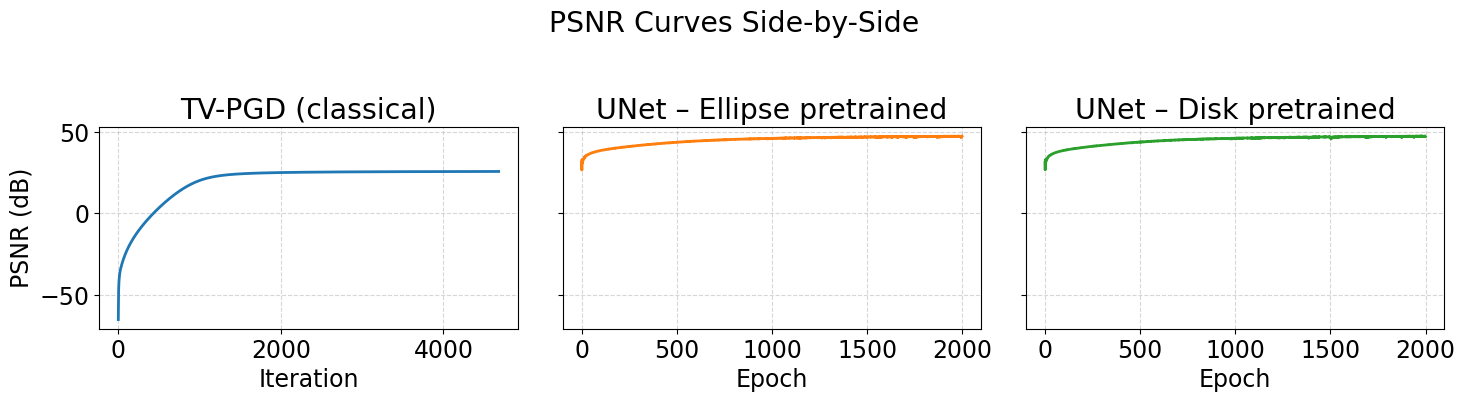

In [34]:
epochs_classic  = list(range(len(psnr_classic)))
epochs_ellipse  = list(range(len(psnr_ellipses)))
epochs_disk     = list(range(len(psnr_disk)))

# 2) Make 1×3 subplots, sharing the y-axis for easy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# TV-PGD (classical)
axes[0].plot(epochs_classic, psnr_classic, color="C0")
axes[0].set_title("TV-PGD (classical)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("PSNR (dB)")
axes[0].grid(linestyle="--", alpha=0.5)

# UNet-ellipse
axes[1].plot(epochs_ellipse, psnr_ellipses, color="C1")
axes[1].set_title("UNet – Ellipse pretrained")
axes[1].set_xlabel("Epoch")
axes[1].grid(linestyle="--", alpha=0.5)

# UNet-disk
axes[2].plot(epochs_disk, psnr_disk, color="C2")
axes[2].set_title("UNet – Disk pretrained")
axes[2].set_xlabel("Epoch")
axes[2].grid(linestyle="--", alpha=0.5)

plt.suptitle("PSNR Curves Side-by-Side", y=1.02)
plt.tight_layout()
plt.show()